# TDA Tutorial 2: Images and Manifolds
By: David Cole and Victor M. Zavala

Based on work done by Dr. Alexander Smith and published [here](https://doi.org/10.1016/j.compchemeng.2021.107463). Code for creating the visualizations was constructured with the help of ChatGPT

To access this notebook in Google Colab, please click below:

<a href="https://githubtocolab.com/zavalab/Tutorials/blob/master/CBE660/TDA2_Images_and_Manifolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Introduction to Manifolds

A manifold is a topological space that locally resembles Euclidian space. You can think of a manifold as being a surface. In TDA tutorial 1, it was noted that we can represent an image as a graph, but we can also think of an image as a manifold (i.e., a surface). In the code snippet below, we generate a Gaussian field and represent it as an image (you can also think of an image as a density field) and then as a 3-D surface (manifold), where the z-axis corresponds to the pixel intensity. The Gaussian field generation is used here because it will provide an example problem later for classification. In the first cell below, we plot the image created by the Gaussian field. In the second cell, we plot the three dimensional representation of the same image

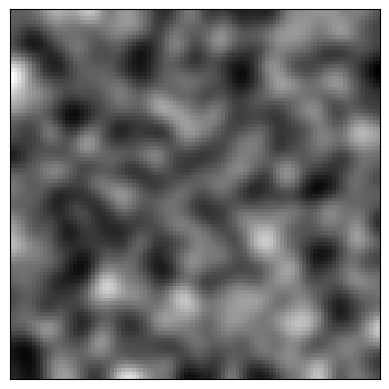

In [2]:
# If running this outside of GoogleCollab, you can uncomment the line below to make the figures interactive
#%matplotlib notebook

import numpy as np
import glob
import pickle
import skimage
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# Generate a gaussian field
def GausField(bump,sigma):
    im = np.array(np.random.normal(0,1,(100,100))> bump).astype(float)
    gim = gaussian_filter(im,sigma = sigma)
    return gim/(np.sqrt(np.mean(gim**2)))

data = GausField(1, 3) - 1

# Plot the field as an image
plt.figure()
plt.imshow(data, cmap = "gray")
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

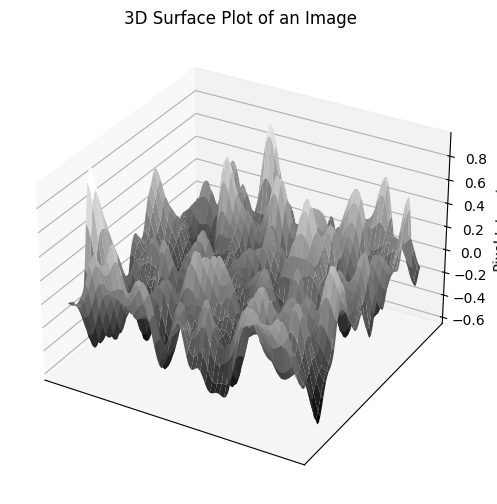

In [3]:
# Plot the image as a 3-D surface

# Define the x and y locations for the data
x = np.arange(data.shape[1])
y = np.arange(data.shape[0])
x, y = np.meshgrid(x, y)

# Create the figure and 3D axes
fig = plt.figure(figsize =(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, data, cmap='gray')  # You can choose other colormaps too

# Optional: Add labels and title
ax.set_zlabel('Pixel Intensity')
ax.set_title('3D Surface Plot of an Image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## TDA on Images and Manifolds

For images and manifolds, we will apply similar approaches as that shown for graphs, where we will compute the Euler Characteristic (EC) of a manifold/surface. As before, the EC will be equal to the number of connected components minus the number of holes. We can likewise still apply the filtration process similar to that shown for graphs, where we filter out pixel values (or surface areas) that correspond to values greater than or less than a certain amount. This results in a new surface that is a subset of the original surface, often with new numbers of holes or connected components. For example, for the surface plot above, we can filter out all values less than 0. This results in several distinct connected components. This process can be repeated for different threshold values to create an EC curve.

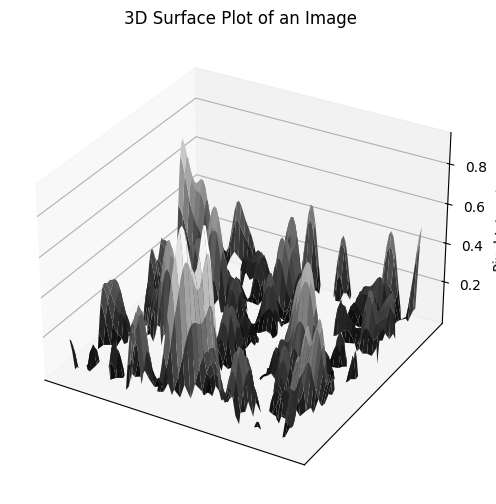

In [ ]:
# Plot the image as a manifold.

# Define the x and y locations for the data
x = np.arange(data.shape[1])
y = np.arange(data.shape[0])

x,y = np.meshgrid(x, y)
filtered_data = np.copy(data)
filtered_data[filtered_data < 0] = np.nan
# Create the figure and 3D axes
fig = plt.figure(figsize =(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, filtered_data, cmap='gray')  # You can choose other colormaps too

# Optional: Add labels and title
ax.set_zlabel('Pixel Intensity')
ax.set_title('3D Surface Plot of an Image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Computing an EC Curve

For the above image, we need a way to compute the number of connected compoments and the number of holes. We will do this through the Python package [Gudhi](https://gudhi.inria.fr/). If you do not have this package installed, you can uncomment and run the cell below to install it.

In [4]:
#!pip install gudhi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.8 MB/s eta 0:00:00


Gudhi provides access to several different TDA approaches and simplifies much of the analysis that we will show below. For the image and manifold problems, we will use Gudhi's cubical complex to represent these problems and to count the number of connected components and holes.

A cubical complex is a representation of a topological structure or space, where the object is made up of rectangular faces of (possibly) different dimensions (see [this link](https://gudhi.inria.fr/python/latest/cubical_complex_user.html) for further details on Gudhi's implementation). A cubical complex does not require that each face of the complex be a perfect square or that perpendicular sides of the complex have the same length. An example of a cubical complex is given below (as given by Gudhi's documentation [here]([this link](https://gudhi.inria.fr/python/latest/cubical_complex_user.html)):

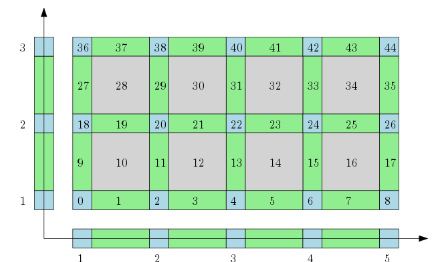

For the image analysis we perform below, Gudhi will create a cubical complex based on the dimension of our data and link the matrix entries to the corresponding cubical cell. Then, when filtration is performed, it will compute the betti numbers (number of connected components and number of holes) from which we can compute the EC. Below, you can see an example of how to compute the EC curve of the image above.

In [5]:
from mpl_toolkits import mplot3d
import glob
import pickle
from scipy.ndimage import gaussian_filter
import numpy as np
import gudhi as gd

In [ ]:
# Define the number of points to use and the filtration start and end
numPoints = 1000;
filtrationStart = -1;
filtrationEnd = 1;

# Define the space of filtrations
filtrations = np.linspace(filtrationStart,filtrationEnd,numPoints);

# Define the cubical complex. This sets the dimensions of the cubical complex
# to be equal to the dimensions of the data, then the values of the data are set
# on their corresponding complex faces via `top_dimensional_cells`
cubeplex = gd.CubicalComplex(dimensions  = [
            np.shape(data)[1],
            np.shape(data)[0]
        ],
        top_dimensional_cells=np.ndarray.flatten(data))

# Before performing filtration, we call the persistence() function. This computes
# the points at which a new hole or component is born or dies
cubeplex.persistence();

# Define a vector for the EC curves
ec = np.zeros(numPoints);

# Loop through the filtration values and compute the EC
for (i,fval) in enumerate(np.flip(filtrations)):
        betti = cubeplex.persistent_betti_numbers(fval,fval);
        ec[i] = betti[0] - betti[1];


With the EC computed, we can now plot the EC curve for this image. At the smallest filtration values (e.g., -1.0), there is only 1 connected components with no holes, so the EC = 1. At the largest filtration values (e.g., 1.0), everything has been filtered out, and there are no connected compoents or holes, and we have that the EC = 0. We can also see that there is an area where holes dominate (\~-0.5 - 0) and an area where connected components dominate (\~0 - 0.5).

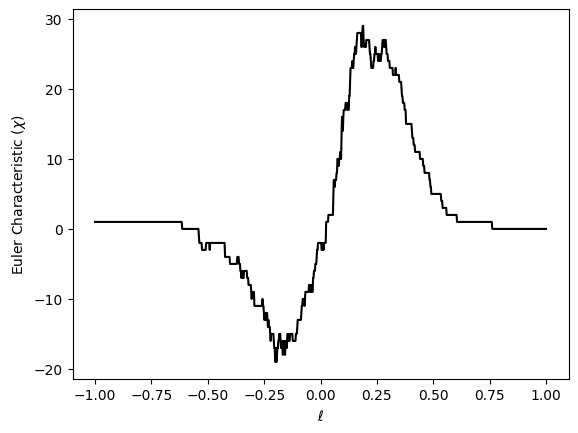

In [ ]:
plt.figure()
plt.plot(filtrations, ec, color = 'k')
plt.xlabel("$\ell$")
plt.ylabel("Euler Characteristic ($\chi$)")
plt.show()

We will visualize the filtered image at different filtration levels to highlight these differences

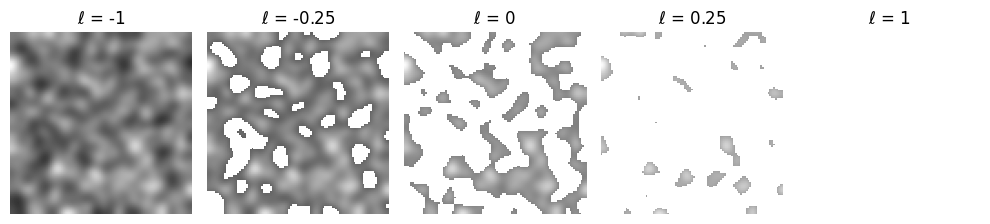

In [6]:
# Make copies of the data for visualization
filtered_image1 = np.copy(data)
filtered_image2 = np.copy(data)
filtered_image3 = np.copy(data)
filtered_image4 = np.copy(data)
filtered_image5 = np.copy(data)

# Filter the images for visualization
filtered_image1[filtered_image1 < -1] = np.nan
filtered_image2[filtered_image2 < -.25] = np.nan
filtered_image3[filtered_image3 < 0] = np.nan
filtered_image4[filtered_image4 < .25] = np.nan
filtered_image5[filtered_image5 < 1] = np.nan

images = [filtered_image1, filtered_image2, filtered_image3, filtered_image4, filtered_image5]
filtration = [-1, -.25, 0, .25, 1]

fig, axes = plt.subplots(1, 5, figsize=(10, 5))

# Loop through each matrix and corresponding subplot axis
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray', vmin = -1, vmax = 1)
    ax.set_title(f"$\ell$ = {filtration[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## Example: Image Classification

With the understanding of images and manifolds, we can now consider a task of classifying a set of images. We will generate these images using Guassian fields. These images are similar to liquid crystals (LC) which have different visual responses based on the environment to which they are exposed. These LCs have been proposed for use as sensors, which can be used to detect dangerous levels of contaminants in the environment. We need a way to readily differentiate the image of a LC in the different environments to allow for identifying critical contaminant levels. We will first generate the images and then compute the EC. We will then show how applying PCA to the EC curves provides separable datat and compare this to applying PCA to a Fourier transform of the images. We will also show how we can use the EC curve to classify these problems.

We will first define the data:

In [9]:
# Define a list for the two different environemtns
data1 = []
data2 = []

# Set the seed so that our Gaussian fields are reproducable

import random
random.seed(10)

# Define a sigma for the Gaussian field; we will use the same sigma for these two fields,
# but use different means for computing
sigma1 = 3
sigma2 = 3

# Compute Gaussian fields
for i in range(100):
    data1.append(GausField(1,sigma1)-1)

for i in range(100):
    data2.append(GausField(1.3,sigma2)-1)

# Define data and labels. Labels are 0 for data1 and 1 for data2
alldata = np.vstack([data1,data2])
labels = np.arange(0,200) >= 100

Next, we will define a function for getting the EC:

In [10]:
# Define a function for getting the EC value. Note that we use new filtration start and end points here
# This is the same approach as shown above, but placed into a function

numPoints = 1000;
filtrationStart = -4;
filtrationEnd = 4;
filtrations = np.linspace(filtrationStart,filtrationEnd,numPoints);

def getEC(data):
    cubeplex = gd.CubicalComplex(
        dimensions  = [
            np.shape(data)[1],
            np.shape(data)[0]
        ],
        top_dimensional_cells=np.ndarray.flatten(data)
    );
    cubeplex.persistence();
    b = np.zeros((numPoints,2)) ;
    ec = np.zeros(numPoints);
    for (i,fval) in enumerate(np.flip(filtrations)):
        betti = cubeplex.persistent_betti_numbers(fval,fval);
        b[i] = [betti[0], betti[1]];
        ec[i] = betti[0] - betti[1];
    return ec;

Now, we can compute the EC for each image

In [11]:
# Compute the EC for each image
# Compute the Fourier transform for each image

ec = []
fft = []
aimages = []

for i in range(len(alldata)):
    aimage = alldata[i] #retrieve the image
    ec.append(getEC(aimage)) # Compute the ec and append it to the list
    fft.append(np.real(np.fft.fftn(aimage)).flatten()) # Compute the Fourier transform and append it
    aimages.append(aimage.flatten())

For reference, we will also plot an image from each of the two environments. While the two images have some differences, it is difficult to immediately identify differences between the two environments.

Text(0.5, 1.0, 'Environment 2')

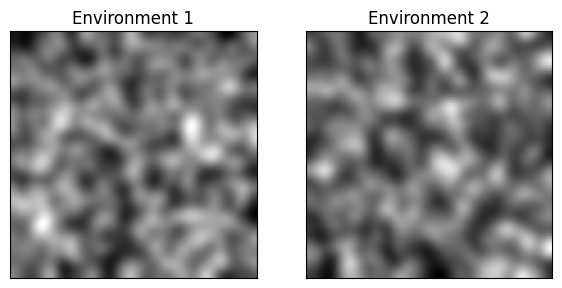

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))

ax[0].imshow(aimages[0].reshape(100,100),cmap = 'gray')
ax[1].imshow(aimages[-1].reshape(100, 100), cmap = 'gray')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_title("Environment 1")
ax[1].set_title("Environment 2")

We will now plot the average EC curve for each environment. Note that the resulting curves have similar shapes but slightly different placement at the different filtration values. We will need some way of capturing these differences

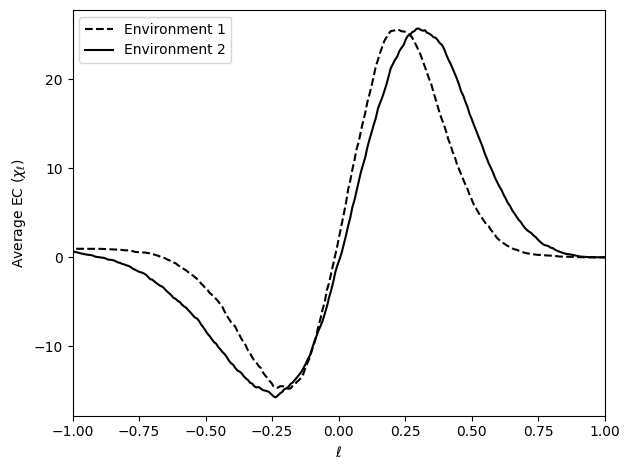

In [21]:
# Convert from a list to an array
ecv = np.vstack(ec)

# Take an average of the EC curves
Mix1EC = np.mean(ecv[0:100],axis = 0)
Mix2EC = np.mean(ecv[100::],axis = 0)

# Plot each environment
plt.figure()
plt.plot(filtrations,Mix1EC, '--k', label = "Environment 1")
plt.plot(filtrations,Mix2EC, 'k', label = "Environment 2")

plt.legend()

plt.xlabel("$\ell$")
plt.ylabel("Average EC ($\chi_{\ell}$)")

plt.xlim(-1,1)

plt.tight_layout()
plt.show()

One way we can quantify the differences in the curves is to perform PCA. This is easy to do within Python by simply calling the `PCA()` function from `sklearn` and retrieving the 200 principle components of our EC curves. We can then plot the first two components for each environment, and we see that there is clear separation from the two different environments.

Text(0.5, 1.0, 'PCA Analysis of EC Curves')

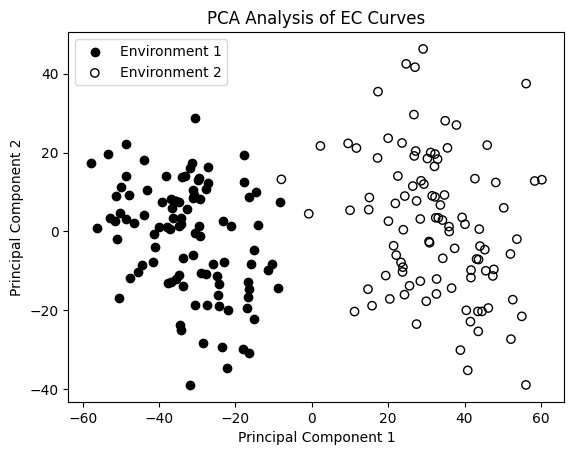

In [22]:
# Perform PCA on the array of EC curves
pca = PCA()
X = pca.fit_transform(ecv)

# Define a figure and plot the principle components
plt.figure()

plt.scatter(X[0:100,0],X[0:100,1], c = 'k', label = "Environment 1")

plt.scatter(X[100::,0],X[100::,1], label = "Environment 2", facecolor ="None", edgecolor = "k")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend()

plt.title("PCA Analysis of EC Curves")

We would like to define a model that will classify these images into one of the two environments. We will use the first two principle components to train a logistic regression model to classify our images based on their environment. We will import sklearn and split our dataset into training and testing sets.

In [23]:
# Define labels for classification: 0 = environment 1, 1 = environment 2

y = np.zeros(200)
y[100::] = 1

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, 0:2], y, test_size = 0.20, random_state = 99)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test,y_test)

1.0

Here, we get a score of 1, meaning that it classified the test set with 100% accuracy. This value could change slightly depending on the size of the test set and the number of images used, but the EC overall is able to effectively capture some of the differences in these images.

For comparison, we will also compare this approach to using PCA on the fourier transformation. The code is similar, but you can see that the fourier transform does not provide separation in the datapoints when using PCA.

Text(0.5, 1.0, 'PCA Analysis of 2D FFT')

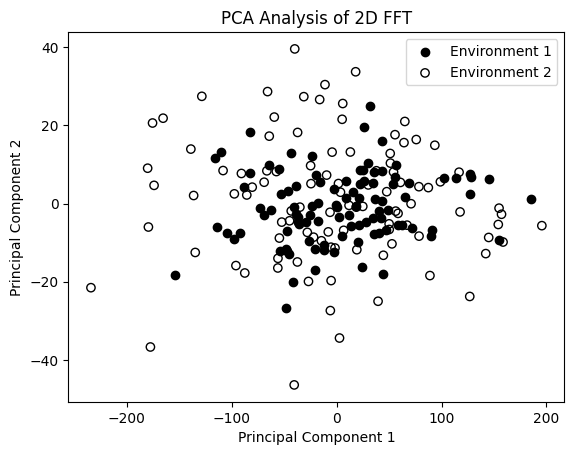

In [15]:
from scipy.stats import zscore

# Compute PCA on fourier transform
X = pca.fit_transform(zscore(np.vstack(fft)))

# Plot figure
plt.figure()
plt.scatter(X[0:100,0],X[0:100,1], c = 'k', label = "Environment 1")

plt.scatter(X[100::,0],X[100::,1], label = "Environment 2", facecolor ="None", edgecolor = "k")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend()

plt.title("PCA Analysis of 2D FFT")